In [1]:
import pandas as pd
import geopandas as gpd
import fiona
import shapely
import numpy as np
import urllib
import os
import pylab as pl
from datetime import datetime as dt
from scipy import stats
import statsmodels.formula.api as smf
import bokeh
import matplotlib as plt
import json
import requests
import io

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Part 1

In [2]:
!wget https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nypuma_17d.zip
    
cmd = "mv nypuma_17d.zip" + os.getenv("PUIDATA")

print(cmd)

os.system(cmd)

--2017-11-28 18:27:31--  https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nypuma_17d.zip
Resolving www1.nyc.gov... 104.106.240.221, 2600:141b:13:297::1500, 2600:141b:13:292::1500
Connecting to www1.nyc.gov|104.106.240.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 761605 (744K) [application/zip]
Saving to: “nypuma_17d.zip.6”

100%[======================================>] 761,605     1.29M/s   in 0.6s    

2017-11-28 18:27:31 (1.29 MB/s) - “nypuma_17d.zip.6” saved [761605/761605]

mv nypuma_17d.zip/home/cusp/jtl417/PUIdata


256

In [3]:
!unzip -d $PUIDATA nypuma_17d.zip

In [4]:
pumashp = gpd.read_file(os.getenv("PUIDATA") + "/nypuma_17d/nypuma.shp")

Text(0.5,1,'PUMAs for NYC')

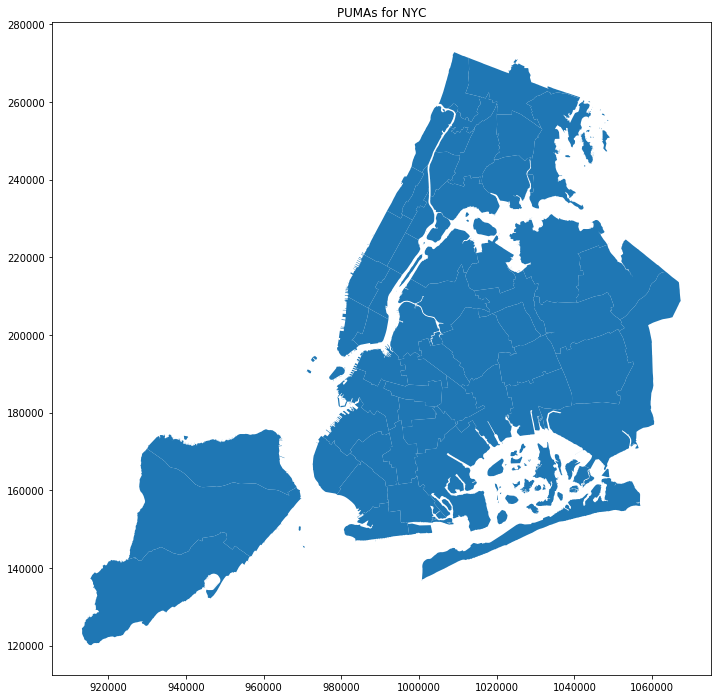

In [5]:
ax = pumashp.plot(figsize=(12,12))
ax.set_title("PUMAs for NYC")

A plot of NYC by PUMA boundary. These boundaries are quite large, especially for less dense urban areas (Staten Island in particular).

# Part 2

In [6]:
from censusAPI import myAPI
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [7]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))

In [8]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [9]:
keyNBB = "B28002_004E"

In [10]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [11]:
#getting the first row of the table: the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + "B28002_001E" +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaPP.head() 

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [12]:
pumaBB = pumaBB.merge(pumaPP, on = "public use microdata area")

In [13]:
pumaBB.drop(["NAME_x", "state_x", "Unnamed: 4_x", "Unnamed: 4_x"], axis = 1, inplace=True)

In [14]:
pumaBB["pcBB"] = 100 * pumaBB.B28002_004E / pumaBB.B28002_001E

In [15]:
pumaBB.head()

,B28002_004E,public use microdata area,B28002_001E,NAME_y,state_y,Unnamed: 4_y,pcBB
0,32607,100,40479,"St. Lawrence County PUMA, New York",36,NaN,80.552879
1,50811,200,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,NaN,75.733321
2,41210,300,51614,"Warren & Washington Counties PUMA, New York",36,NaN,79.842678
3,36075,401,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,NaN,81.433409
4,47786,402,61146,Oneida County (Central)--Greater Utica & Rome ...,36,NaN,78.150656


In [16]:
PUIdata = os.getenv("PUIDATA")

In [17]:
!unzip -d $PUIDATA ACS_16_1YR_GCT2801.ST50.zip

unzip:  cannot find or open ACS_16_1YR_GCT2801.ST50.zip, ACS_16_1YR_GCT2801.ST50.zip.zip or ACS_16_1YR_GCT2801.ST50.zip.ZIP.


In [18]:
bbpc = pd.read_csv("ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])

bbpc.drop(0, inplace=True)

In [19]:
bbpc['GCT_STUB.target-geo-id2'] = bbpc['GCT_STUB.target-geo-id2'].astype(int)

In [20]:
bbpc.HC01 = bbpc.HC01.astype(float)
bbpc.HC02 = bbpc.HC02.astype(float)

In [21]:
bbpc = bbpc[bbpc["GCT_STUB.target-geo-id2"] > 0]

In [22]:
bbpc["gid"] = bbpc["GCT_STUB.target-geo-id2"].astype(str)

In [23]:
bbpc.gid = bbpc.gid.str.slice(start=-4, stop = None)

In [24]:
bbpc.gid = bbpc.gid.astype(int)

In [25]:
bbpc.gid = bbpc["GCT_STUB.target-geo-id2"] - 3600000

In [26]:
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "HC01", "gid"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))

diff_.describe()

,pcBB,HC01,gid,diff
count,145.000000,145.000000,145.000000,145.000000
mean,81.845478,81.843448,2826.827586,0.026217
std,7.063369,7.065358,1210.054822,0.014480
min,54.932945,54.900000,100.000000,0.000178
25%,77.770257,77.800000,1900.000000,0.012252
50%,82.826141,82.800000,3208.000000,0.027230
75%,87.305077,87.300000,3809.000000,0.039090
max,93.404143,93.400000,4114.000000,0.049872


In [27]:
#choropleth of the percentage of internet axcess
pumashp.PUMA = pumashp.PUMA.astype(int)
pumashp = pumashp.merge(diff_, left_on = "PUMA", right_on = "gid")

Text(0.5,1,'% of Households with Broadband Access')

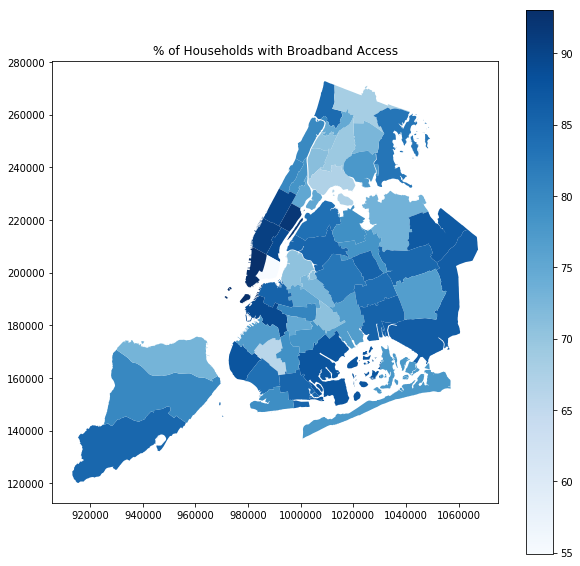

In [28]:
ax = pumashp.plot(column="pcBB", figsize = (10,10), cmap="Blues", legend = True)
ax.set_title("% of Households with Broadband Access")

This map shows the % of people living in each PUMA with access to broadband. The range is between 55 (lighter blue) and 100 (darker blue), so more than half of people in every PUMA have access to broadband. Nonetheless, there is a disparity across PUMAs. Lower-income communities, by and large, seem to have less access to broadband then wealthier communities.

# Part 4

In [29]:
linkNYC = pd.read_csv("https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW9_fb55/linkNYClocations.csv")

In [30]:
from fiona.crs import from_epsg
from shapely.geometry import Point
from geopandas import GeoDataFrame


geometry_link = [Point(xy) for xy in zip(linkNYC.longitude, linkNYC.latitude)]

crs = {'proj':'longlat', "epsg" : "4326"}

linkNYC_shp = GeoDataFrame(linkNYC, crs=crs, geometry=geometry_link)
linkNYC.head() #4326
linkNYC_shp = linkNYC_shp.to_crs(epsg=2263)
pumashp = pumashp.to_crs(epsg=2263)

Text(0.5,1,'Link sites overlaid on a map of % broadband access')

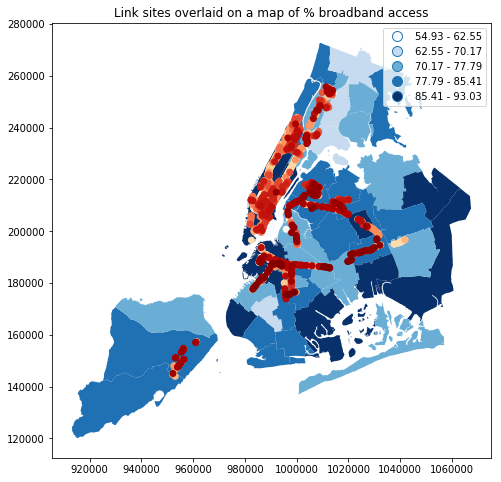

In [31]:
ax = pumashp.plot(column="pcBB", cmap="Blues", figsize=(8,8), scheme = "equal_interval", k = 5, legend = True)
linkNYC_shp.plot(ax = ax, cmap="OrRd")
ax.set_title("Link sites overlaid on a map of % broadband access")

This is the same as the previous map, but with a different grouping schema (5 equal intervals as the cuttoff for % with access to broadband). Furthermore, linknyc locations are visualized as orange/red dots above the chloropleth. There are clearly less linknyc locations in Staten Island, part of Queens and Brooklyn. These places lack broadband access, so there seems to be some inequity there.

# Part 5

In [32]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + "B00001_001E" +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [33]:
pumaPop.drop(["NAME", "state", "Unnamed: 4"], axis = 1, inplace=True)

In [34]:
pumashp = pumashp.merge(pumaPop, left_on = "gid", right_on = "public use microdata area")

In [35]:
linkpp = pd.DataFrame(gpd.sjoin(pumashp, linkNYC_shp, how = "inner").groupby(by = "PUMA")["link_site"].count())

In [36]:
linkpp["PUMA"] = linkpp.index

In [37]:
pumashp = pumashp.merge(linkpp, on = "PUMA", how = "left")

In [38]:
pumashp["linkNYCp100p"] = 100 * (pumashp.link_site/pumashp.B00001_001E)

In [39]:
pumashp.linkNYCp100p.describe()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%            NaN
50%            NaN
75%            NaN
max      15.141540
Name: linkNYCp100p, dtype: float64

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


Text(0.5,1,'Stations per 100 People')

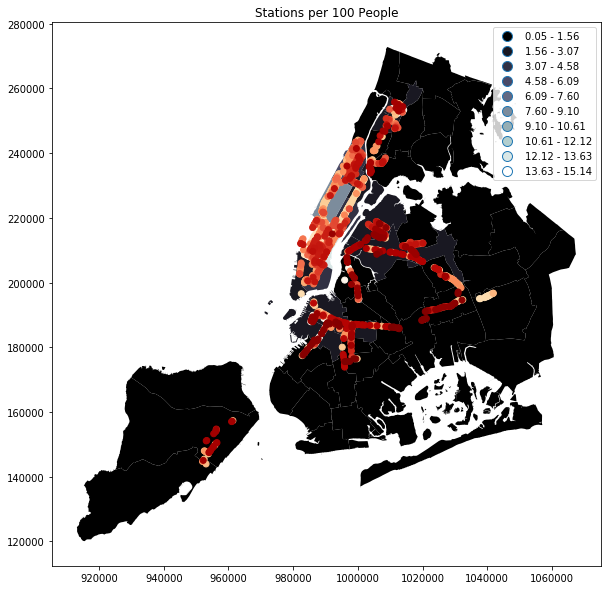

In [44]:
ax = pumashp.plot(column="linkNYCp100p", cmap="bone", figsize=(10,10), scheme="equal_interval", k = 10, legend = True)
linkNYC_shp.plot(ax = ax, cmap="OrRd")
ax.set_title("Stations per 100 People")

This is a map where the basemap is colorcoded by the number of link stations per 100 people in a PUMA zone. Linknyc stations are displayed again as points. It is clear that everywhere outside Manhattan has much less access to linknyc stations, given that their suggests that they fall into the lowest two buckets.